# Exp8. 뉴스기사 요약해보기


# 🗼 목차
## [추상적 요약]
Step 0. 라이브러리 불러오기  

Step 1. 데이터 수집하기   

Step 2. 데이터 전처리하기    
     2.1 데이터 정리하기  
     2.2 훈련데이터, 테스트데이터 나누기  
     2.3 정수 인코딩  
     
Step 3. 모델 설계 (훈련단계 모델)  
     3.1 인코더(encoder) 설계  
     3.2 디코더(decoder) 설계  
     3.3 디코더의 출력층 설계  
     3.4 어텐션 메커니즘  
     
Step 4. 모델 훈련하기  

Step 5. 인퍼런스 모델 구현하기 (동작 모델)  

Step 6. 모델 테스트  
     6.1 정수 시퀀스를 텍스트 시퀀스로 변환  
     6.2 실제 요약 vs 예측된 요약  
     6.3 결과 정리  
     6.4 각 시도 별 예측 요약 문장    
     
     
## [추출적 요약]
Step 0. 라이브러리 불러오기  
Step 1. 데이터 불러오기  
Step 2. 추출적 요약하기

---
---
---

# [추상적 요약]

# Step 0. 라이브러리 불러오기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


---

# Step 1. 데이터 수집하기

## 1.1 데이터 다운로드

* [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)에서 데이터를 가져왔다.

In [2]:
import pandas as pd
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

## 1.2 데이터 확인
* 불러온 데이터는 **text, headlines**로 구성되어 있다.
* 추상적 요약 : text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델 학습이 가능하다.
* 추출적 요약 : 오직 text열만을 사용하여 요약한다.

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
print('text의 개수 : ', len(data['text']))
print('headlines의 개수 : ', len(data['headlines']))

text의 개수 :  98401
headlines의 개수 :  98401


---

# Step 2. 데이터 전처리하기

## 2.1 데이터 정리하기

### 2.1.1 중복 샘플, NULL 값 제거

In [5]:
print('text에서 중복 제외한 샘플 수 : ', data['text'].nunique())
print('headlines에서 중복 제외한 샘플 수 : ', data['headlines'].nunique())

text에서 중복 제외한 샘플 수 :  98360
headlines에서 중복 제외한 샘플 수 :  98280


* **data 중 text만 중복 제거한 이유**  
    → 짧은 단어로 요약되는 경우, 다른 text라도 동일한 headline이 나올 수 있다.  
    → 그렇기에 headline은 중복 제거를 하지 않는다. 중복 제거를 할 수는 있지만 그럴 경우 데이터의 양이 줄어들기 때문에 headlines는 중복 제거를 하지 않았다.

In [6]:
# drop_duplicates() : 중복 샘플 제거
# inplace = True : DataFrame 타입 값을 return하지 않고 data 내부를 직접적으로 바꿈

data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 : ', (len(data)))
print('중복 제거한 text의 개수 : ', len(data['text']))

전체 샘플수 :  98360
중복 제거한 text의 개수 :  98360


In [7]:
# text, headline의 null 값이 있는지 확인

print(data.isnull().sum()) 

headlines    0
text         0
dtype: int64


### 2.1.2 텍스트 정규화, 불용어 제거

In [8]:
# 텍스트 정규화 (정규화 사전에서 가져옴)

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# NLTK에서 제공하는 불용어 리스트

print('불용어 개수 : ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 :  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', '

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlinse)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


### 2.1.3 전체 text 데이터에 대한 전처리
* text 데이터는 불용어 제거를 한다.

In [11]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
print('text 전처리 후 결과 : ', clean_text[:5])

text 전처리 후 결과 :  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insu

### 2.1.4 headlines 데이터에 대한 전처리
* headlines 데이터는 불용어 제거를 하지 않는다. (요약된 문장으로 따로 불용어 처리를 하지 않아도 된다고 생각된다.)

In [12]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))   # 불용어 제거를 수행하지 않는다는 의미에서 False 추가

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 2.1.5 전처리 후 빈 샘플 확인

* 텍스트 정제의 과정을 거치다보면 빈 샘플이 생길 수도 있기에 확인하고 제거해줄 필요가 있다.

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace = True)   # 빈 값을 Null 값으로 변환
print('=3')

=3


In [14]:
data.isnull().sum()      # Null 값이 생겼는지 확인 → 다행히 없음!

headlines    0
text         0
dtype: int64

## 2.2 훈련데이터, 테스트데이터 나누기

### 2.2.1 샘플 최대 길이 정하기
* 샘플의 최대 길이를 정하기 위해서는 text, headlines에 있는 샘플들의 길이를 알아야 한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
-----------------------
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


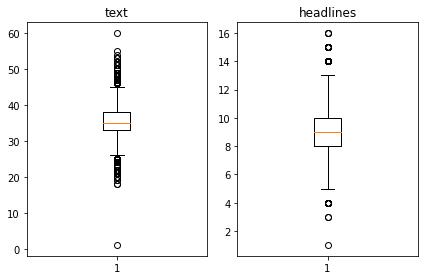

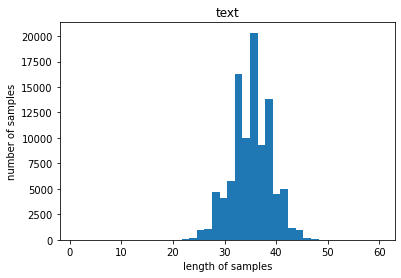

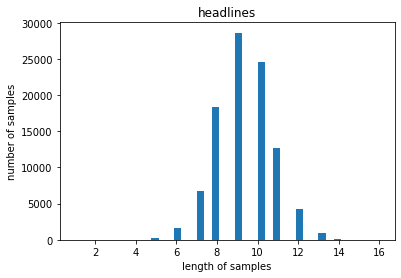

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

print('-----------------------')

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')

plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* bloxplot을 통해 이상치로 표현되는 부분만 제거해보았다.

In [16]:
# Text 최대 길이, headlines의 최대 길이 임의로 정하기

text_max_len = 45
headlines_max_len = 13
print('=3')

=3


* 위에서 설정한 text, headlines의 최대 길이 안에 데이터 샘플이 각 데이터의 몇 %가 들어오는지 확인을 해본다.

In [17]:
# below_threshold_len : 데이터의 몇 %가 최대 길이 안에 들어오는지 계산하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


* text, headlines의 샘플들의 99% 이상이 최대 길이(text = 45, headlines = 13)안에 들어간다.

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [19]:
# 정해진 길이에 맞춰 자르지 않고
# 정해진 길이보다 길면 제외하는 방법으로 데이터 정제

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)] # 43보다 길면 제외
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]  # 12보다 길면 제외
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97863


* 이전 샘플수 : 98360
* 현재 샘플수 : 95935
* 제거된 샘플수 : 2435

### 2.2.2 시작토큰, 종료토큰 추가
* 디코더는 시작 토큰(sostoken)을 입력받아야 문장을 생성하기 시작하고 종료 토큰(eostoken)을 예측한 순간에 문장 생성을 멈춘다.
* seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 한다.

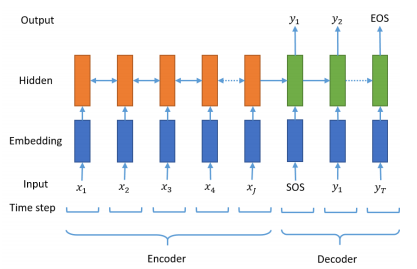

* headlines 데이터에만 시작토큰(sostoken ), 종료토큰( eostoken)을 추가한다.

In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x:'sostoken ' + x)  
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


* encoder_input, decoder_input, decoder_target을 다시 numpy 타입으로 저장한다.

In [21]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input']) 
decoder_target = np.array(data['decoder_target'])
print('=3')

=3


### 2.2.3 훈련데이터, 테스트데이터 분리
* 분리 패키지를 사용하지 않고 직접 코딩하여 훈련데이터, 테스트데이터 분리한다.

* encoder_input과 크기와 형태가 같으며 순서가 섞인 정수 시퀀스를 만든다.

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[51602 10665 65336 ...  2852 84898 36233]


* 위에서 만든 정수 시퀀스를 통해 `encoder_input`, `decoder_input`, `decoder_target`의 샘플 순서를 정의한다.

In [23]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의 → 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


* 훈련데이터와 테스트데이터를 8:2로 분리한다.

In [24]:
n_of_val = int(len(encoder_input) * 0.2)

print('테스트 데이터의 수 : ', n_of_val)

테스트 데이터의 수 :  19572


In [25]:
encoder_input_train = encoder_input[:-n_of_val]     # 훈련 데이터
decoder_input_train = decoder_input[:-n_of_val]     # 훈련 레이블
decoder_target_train = decoder_target[:-n_of_val]   

encoder_input_test = encoder_input[-n_of_val:]     # 테스트 데이터
decoder_input_test = decoder_input[-n_of_val:]     # 테스트 레이블
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))

print('--------------')

print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
--------------
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


## 2.3 정수 인코딩
* 컴퓨터는 텍스트보다 숫자를 잘 처리하기에 텍스트를 숫자로 바꾸는 작업이 정수 인코딩이다.
* 단어에 정수를 부여하는 방법에는 여러가지가 있다.
* 해당 프로젝트에서는 단어를 빈도수 순으로 정렬한 단어집합을 만들고 빈도수가 높은 순서대로 정수를 부여하는 방법을 사용한다.

### 2.3.1 데이터 인코딩

#### 2.3.1.1 단어집합(vocabulay) 만들기

* 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장한다.
* `src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어있다.

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
src_word_index = src_tokenizer.word_index

print('데이터 단어 집합의 크기 : ', len(src_tokenizer.word_index))

데이터 단어 집합의 크기 :  69409


* 등장 빈도수가 **'7회'** 미만인 단어들이 차지하는 비중 확인을 해본다.

In [27]:
threshold = 7    # 등장 빈도수

total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold(7)보다 작은 단어의 개수를 카운트

total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold(7)보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('-------------')
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외한 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('-------------')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69409
-------------
등장 빈도가 6번 이하인 희귀 단어의 수: 47280
단어 집합에서 희귀 단어를 제외한 단어 집합의 크기 22129
-------------
단어 집합에서 희귀 단어의 비율: 68.11796741056635
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4969936667356443


▶▶ 희귀 단어가 등장하는 빈도의 비율이 **3.48%** 이다.
* 정수 인코딩 과정에서 제외하기
* 훈련 데이터에서 제거하기  
→ 희귀단어를 제외한 단어 집합의 크기는 21,870이므로 단어 집합의 크기를 22,000으로 제한한다. (희귀단어를 조금 포함했다.)

In [28]:
src_vocab = 22000

src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('슝')

슝


#### 2.3.1.2 정수 인코딩 진행

* `texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 수행한다.
* 단어 집합의 크기를 22,000으로 제한하였다.  
    → 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터가 존재하지 않는다.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)   # 훈련 데이터
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)     # 테스트 데이터

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[9, 63, 1, 509, 62, 345, 743, 419, 2757, 3997, 345, 36, 185, 62, 345, 20578, 62, 2106, 2980, 5190, 66, 367, 186, 79, 32, 236, 1823, 7862, 20578, 345, 9, 4], [575, 33, 1250, 176, 727, 790, 94, 607, 1286, 9634, 4199, 3014, 208, 746, 890, 392, 3029, 1, 1286, 1072, 189, 598, 117, 5155, 1931, 61, 172, 150, 3665, 208, 2804, 3301, 167, 88, 22], [67, 441, 438, 279, 5468, 3704, 1989, 9297, 1588, 1214, 204, 203, 8967, 586, 15304, 224, 968, 215, 438, 943, 1588, 11186, 1611, 906, 1612, 6162, 2001, 1, 24, 7979, 438, 561]]


### 2.3.2 decoder_input_train (훈련 레이블)

* 현재 생성된 단어 집합은 `tar_tokenizer.word_index`에 저장한다.
* `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어있다.

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_word_index = tar_tokenizer.word_index

print('레이블 단어 집합의 크기 : ', len(tar_tokenizer.word_index))

레이블 단어 집합의 크기 :  30076


#### 2.3.2.1 단어집합(vocabulay) 만들기
* 등장 빈도수가 **'6회'** 미만인 단어들이 차지하는 비중 확인을 해본다.

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('-------------')
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('-------------')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30076
-------------
등장 빈도가 5번 이하인 희귀 단어의 수: 19716
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10360
-------------
단어 집합에서 희귀 단어의 비율: 65.55393004388883
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.676921854278321


▶▶ 희귀 단어가 등장하는 빈도의 비율이 **4.65%** 이다.

* 정수 인코딩 과정에서 제외하기
* 훈련 데이터에서 제거하기
* 희귀단어를 제외한 단어 집합의 크기는 10,410이므로 단어 집합의 크기를 10,000으로 제한한다. (깔끔하게 10,000으로 단어 집합의 크기를 조정하였다.)

In [32]:
tar_vocab = 10000

tar_tokenizer = Tokenizer(num_words=tar_vocab)   # 단어 집합의 크기를 11,450으로 제한
tar_tokenizer.fit_on_texts(decoder_input_train)  # 단어 집합 재생성 (훈련 레이블 입력)
tar_tokenizer.fit_on_texts(decoder_target_train) # 단어 집합 재생성 (훈련 레이블 출력)

print('슝')

슝


#### 2.3.2.2 정수 인코딩 진행

* `texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 수행한다.
* 단어 집합의 크기를 10,000으로 제한하였다.  
    → 10,0000이 넘는 숫자들은 정수 인코딩 후에는 데이터 존재하지 않는다.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)    # 훈련 레이블
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)    #  테스트 레이블
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('-------------')
print('target')
print('target ',decoder_target_train[:5])

input
input  [[1, 23, 3, 137, 474, 4, 3561, 158, 3765], [1, 64, 1091, 1354, 5, 9507, 4824, 3, 3106, 4126, 87, 1421], [1, 75, 339, 311, 605, 974, 11, 2509, 868, 1555], [1, 1443, 108, 2424, 890, 4011, 333, 9, 92], [1, 2902, 68, 5183, 2461, 177, 4]]
-------------
target
target  [[23, 3, 137, 474, 4, 3561, 158, 3765, 2], [64, 1091, 1354, 5, 9507, 4824, 3, 3106, 4126, 87, 1421, 2], [75, 339, 311, 605, 974, 11, 2509, 868, 1555, 2], [1443, 108, 2424, 890, 4011, 333, 9, 92, 2], [2902, 68, 5183, 2461, 177, 4, 2]]


### 2.3.3 빈 샘플 확인

* 전체 데이터에서 빈도수가 낮은 단어가 삭제하였다.  
    → 빈도수가 낮은 단어만으로 구성된 샘플은 빈 샘플이 되었을 가능성이 있다.
* text는 길이가 길었기에 큰 문제는 없으나
* headlines는 평균 길이가 9로 다소 짧기에 문제가 될 수 있다.

**🔥 주의할 점 🔥**

* decoder_input에는 sostoken, decoder_target에는 eostoken이 추가되어 있다. 
* 그렇기에 길이가 0이 된 요약문의 실제 길이는 1로 나올 것! (sostoken, eostoken때문에)

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('--------------')

print('빈 샘플 삭제한 훈련 데이터의 개수 :', len(encoder_input_train))
print('빈 샘플 삭제한 훈련 레이블의 개수 :', len(decoder_input_train))

print('--------------')

print('빈 샘플 삭제한 테스트 데이터의 개수 :', len(encoder_input_test))
print('빈 샘플 삭제한 테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
--------------
빈 샘플 삭제한 훈련 데이터의 개수 : 78290
빈 샘플 삭제한 훈련 레이블의 개수 : 78290
--------------
빈 샘플 삭제한 테스트 데이터의 개수 : 19572
빈 샘플 삭제한 테스트 레이블의 개수 : 19572


### 2.3.4 패딩하기
* 서로 다른 길이의 샘플을 같은 길이로 맞춰주는 패딩 작업을 한다.
* 위에서 정했던 최대 길이(text = 45, headlines = 13)로 패딩 작업을 할 예정이다.
* 문장의 뒤에 숫자 0을 추가한다.

In [35]:
# text 데이터(train, test 데이터)
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
# headlines 데이터(train 데이터)
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
# headlines 데이터(test 데이터)
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


---

# Step 3. 모델 설계 (훈련단계 모델)

#### LSTM(Long-Short Term Memory models)
* RNN(Recurrent Neural Network)의 hidden state에 memory cell state를 추가하여 기존 RNN의 gradient vanishing problem을 해결한 모델
* gradient vanishing problem : input되는 학습 데이터의 길이가 길어질수록 back-propagation 단계에서 gradient가 줄어들어 W와 bias가 유의미하게 변하지 못하는 문제
* LSTM은 `cell state`를 추가하여 과거의 정보를 얼마나 읹을지, `time stamp`에서 input된 정보를 얼마나 기억할지를 결정함
  
  
#### dropout, recurrent dropout
* dropout : 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결해줌
* recurrent dropout : 레이어가 아닌 time step마다 dropout을 해주어 이것 또한 과적합을 해결해줌

#### Variational Dropout
dropout과 recurrent dropout 모두 사용한 것
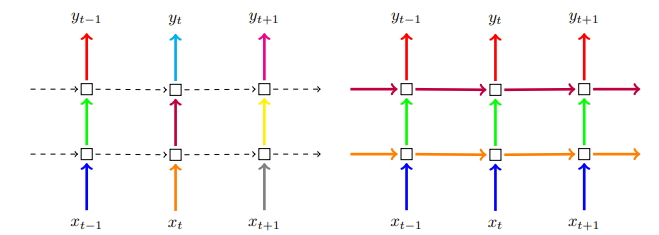  
  
* [LSTM 참고자료](https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)
* [LSTM + dropout 참고자료](https://medium.com/curg/deep-rnn-%EC%A0%95%EA%B7%9C%ED%99%94%EA%B0%80-%EA%B6%81%EA%B8%88%ED%95%B4-7d69f3bbc171)

## 3.1 인코더(encoder) 설계

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128   # 임베딩 벡터의 차원
hidden_size = 256     # hidden state의 크기 (LSTM에서 얼만큼의 수용력을 가질지를 정하는 파라미터, LSTM의 용량크기, 뉴런 개수로 생각하면 됨)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 3.2 디코더(decoder) 설계
* 인코더(encoder)와 거의 동일하다.
* LSTM 입력을 정의할 때, initial_state의 인자값으로 **인코더의 hidden state와 cell state의 값**을 넣어줘야 한다.

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## 3.3 디코더의 출력층 설계
* 디코더의 출력층에서 headlines의 단어장인 `tar_vocab`의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다.  
    → 그렇기에 Dense 인자로 `tar_vocab`을 주고, 활성화 함수로 `softmax` 함수 사용한다.  
    → 하지만 나는 활성화 함수로 가장 많이 쓰인다는 `relu` 함수를 사용해보았다.
* 가장 기본적인 seq2seq을 설계한다.
* [활성화 함수 참고 자료](https://pgnv.tistory.com/17)

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='relu')  
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3.4 어텐션 메커니즘
* 어텐션 메커니즘 : 디코더에서 출력 결과를 예측할 때,인코더의 Hidden State들을 다시 한 번 참고해주는 방법
* 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용한다.
* 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동한다.

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

---

# Step 4. 모델 훈련하기

* batch_size를 256, 528, 1024로 하였을 때 loss 값이 큰 차이가 없어서 빠르게 에포크가 작동되는 1024로 설정하였다.
* optimizer도 기존의 `rmsprop`으로 진행하였다가 `adam`으로도 변경을 해보았지만, 최종 프로젝트에서는 `rmsprop`로 진행하고자 한다.
* [Optimizer 참고자료](https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam)

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)   # val_loss가 증가하는 현상이 2회 이상 관측되면 학습 중지
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=1024, callbacks=[es], epochs=50)

Epoch 1/50
77/77 [==============================] - 71s 803ms/step - loss: 5.6480 - val_loss: 5.2082
Epoch 2/50
77/77 [==============================] - 62s 809ms/step - loss: 5.1459 - val_loss: 4.9852
Epoch 3/50
77/77 [==============================] - 63s 814ms/step - loss: 4.9261 - val_loss: 4.8133
Epoch 4/50
77/77 [==============================] - 63s 813ms/step - loss: 4.7597 - val_loss: 4.6505
Epoch 5/50
77/77 [==============================] - 63s 819ms/step - loss: 4.5897 - val_loss: 4.5242
Epoch 6/50
77/77 [==============================] - 62s 810ms/step - loss: 4.4236 - val_loss: 4.3717
Epoch 7/50
77/77 [==============================] - 62s 808ms/step - loss: 4.2699 - val_loss: 4.2652
Epoch 8/50
77/77 [==============================] - 62s 808ms/step - loss: 4.1298 - val_loss: 4.1565
Epoch 9/50
77/77 [==============================] - 62s 808ms/step - loss: 4.0059 - val_loss: 4.0559
Epoch 10/50
77/77 [==============================] - 62s 809ms/step - loss: 3.8918 - val_lo

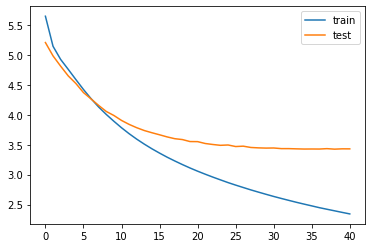

In [41]:
# 훈련데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

---

# Step 5. 인퍼런스 모델 구현하기 (동작 모델)
* 테스트 단계에서 '정수 인덱스 행렬'로 존재하던 텍스트 데이터를 실제 데이터로 복원하는 작업이다.

## 5.1 사전 3개 준비

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


## 5.2 인퍼런스를 위한 모델 설계
* 정답 문장이 없는 인퍼런스 단계(실제로 동작하는 단계)에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 한다.  
    → 인퍼런스를 위한 모델 설계를 별도로 해주어야 하며 이 때, 인코더와 디코더 모델을 분리해서 설계한다.

### 5.2.1 인코더 모델 설계
* 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용한다. 이는 뒤의 함수 `decode_sequence()`에 구현한다.
* 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 `state_h`와 `state_c`를 버리지 않는다.

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


### 5.2.2 디코더 모델 설계 (어텐션 메커니즘 사용)

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


### 5.2.3 단어 시퀀스를 완성하는 함수

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


---

# Step 6. 모델 테스트

## 6.1 정수 시퀀스를 텍스트 시퀀스로 변환
* text의 정수 시퀀스 : 숫자 0 제외(패딩)
* headlines의 정수 시퀀스 : 숫자 0(패딩), 시작 토큰의 인덱스, 종료 토큰의 인덱스 제외

In [46]:
# text의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):        # 숫자 0을 제외    
            temp = temp + src_index_to_word[i]+' '
    return temp

# headlines의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:    # 숫자 0, 시작 토큰, 종료 토큰의 인덱스 제외
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


## 6.2 실제 요약 vs 예측된 요약

In [47]:
for i in range(50, 100):
    print(i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

50
원문 : pm narendra modi saturday met european council president donald tusk european commission president jean claude juncker sidelines summit argentina discussions focused strengthening relations india european union including joint efforts counter terrorism forms external affairs ministry said 
실제 요약 : pm eu leaders discuss ways to fight terrorism at meet 
예측 요약 :  pm modi to enhance summit on prez in paris deal


51
원문 : august us experience first coast coast total solar eclipse years eclipse would pass oregon west coast crossing towards south carolina east coast total eclipse last minutes seconds people canada central america even upper part south america would witness partial eclipse 
실제 요약 : solar eclipse to cover us entire st time in yrs 
예측 요약 :  solar eclipse moon moon moon could be flown to moon lunar eclipse


52
원문 : presenting first budget since us restored sanctions iran president hassan rouhani said america goal bring iran islamic system knees us fail sanctions doubt af

## 6.3 결과 정리

In [48]:
results = {'text 최대길이' : [45, 42, 45, 45, 45, 45, 45],
           'headlines 최대길이' : [13, 11, 13, 13, 13, 13, 13],
           'text 등장빈도수' : [7, 7, 6, 7, 7, 7, 7],
           'headlines 등장빈도수' : [6, 6, 4, 6, 6, 6, 6],
           '활성화함수' : ['softmax', 'softmax', 'softmax', 'softmax', 'softmax', 'relu', 'relu'],
           'optimizer' : ['rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'adam'],
           'batch size' : [256, 528, 528, 528, 1024, 1024, 1024],
          'loss' : [2.4922, 2.9316, 2.6033, 2.4288, 2.4459, 2.4157, 2.3237],
          'val_loss' : [3.3288, 4.2006, 3.5155, 3.3883, 3.4213, 3.4117, 3.3899]}

pd_results = pd.DataFrame(results)
pd_results

,text 최대길이,headlines 최대길이,text 등장빈도수,headlines 등장빈도수,활성화함수,optimizer,batch size,loss,val_loss
0,45,13,7,6,softmax,rmsprop,256,2.4922,3.3288
1,42,11,7,6,softmax,rmsprop,528,2.9316,4.2006
2,45,13,6,4,softmax,rmsprop,528,2.6033,3.5155
3,45,13,7,6,softmax,rmsprop,528,2.4288,3.3883
4,45,13,7,6,softmax,rmsprop,1024,2.4459,3.4213
5,45,13,7,6,relu,rmsprop,1024,2.4157,3.4117
6,45,13,7,6,relu,adam,1024,2.3237,3.3899


## 6.4 각 시도 별 예측 요약 문장

### <1번 시도>
* 원문 : nawazuddin siddiqui said revealing details relationships ex girlfriends niharika singh sunita biography ordinary life memoir biggest mistake life taken names biography added niharika sunita accused nawazuddin making false claims relationships publicity  
나와즈딘 시디키는 전 여자친구인 니하리카 싱 수니타 전기에서 가장 큰 실수를 한 자서전인 니하리카 수니타가 거짓 주장 관계를 홍보하고 있다고 덧붙였다.  
  
* 실제 요약 : biggest mistake of my life nawazuddin on his biography  
그의 전기에 대한 내 인생의 가장 큰 실수  
  
* 예측 요약 :  nawazuddin nawazuddin was not nawazuddin on biography  
나와주딘 나와주딘은 전기에 나와주딘이 아니었다.  
  
▶ nawazuddin이라는 단어가 예측 요약 문장에 총 3번이 들어간 것을 확인할 수 있다.val_loss가 가장 낮았음에도 요약이 잘 되지 않은 것을 확인할 수 있다.

### <2번 시도 / 3번 시도>  
* 원문 : serbian football club red star open top bus caught fire team celebrating th league title victory parade serbian capital according reports blaze started player carrying accidentally set fire oil leaked bus club statement confirmed players hurt incident  
세르비아 축구 클럽 레드 스타 오픈 탑 버스가 리그 우승 퍼레이드 세르비아 수도를 축하하던 중 화재가 발생, 선수들이 부상을 입은 것으로 확인됐다.
* 실제 요약 : football team open top bus catches fire during celebration  
축구팀 오픈 탑 버스가 축하하는 동안 불이 붙다.
* 예측 요약 :  injured as bus bus catches fire in kerala  
케랄라에서 버스에 불이 나서 부상당함  
  
▶ 'kerala'가 갑자기 어디에서 나왔는지는 모르겠지만, 그것만 제외하면 나름 요약이 잘되었다.   
▶ 신기하게도 2번 시도와 3번시도는 최대 길이 등 다르게 설정한 것이 많고 val_loss가 꽤 차이가 남에도 불구하고 동일하게 나온 것들이 꽤나 있었다. 이 부분은 굉장히 의아하다.

### <4번 시도>
* 원문 : serbian football club red star open top bus caught fire team celebrating th league title victory parade serbian capital according reports blaze started player carrying accidentally set fire oil leaked bus club statement confirmed players hurt incident  
세르비아 축구 클럽 레드 스타 오픈 탑 버스가 리그 우승 퍼레이드 세르비아 수도를 축하하던 중 화재가 발생, 선수들이 부상을 입은 것으로 확인됐다.
* 실제 요약 : football team open top bus catches fire during celebration  
축구팀 오픈 탑 버스가 축하하는 동안 불이 붙다.
* 예측 요약 :  wins real madrid win in th game of game in russia  
러시아 게임에서 레알 마드리드가 이기다.  
  
▶ 2,3번 시도와 동일한 원문인데 전혀 다른 문장이 출력되었다. val_loss가 낮아서 잘 요약되지 않았을까 기대를 하였지만 훨씬 좋지 않은 요약이다.

### <5번 시도>
* 원문 : us president donald trump administration scrapped obama era guidance investigating campus sexual assault allowing universities decide standards evidence used investigations us education secretary said rules unfairly accused students rights groups claimed new laws discourage students reporting cases  
미국 대통령 도널드 트럼프는 대학들이 조사를 이용한 표준 증거를 결정하도록 허용하면서 캠퍼스 성폭력을 조사하는 오바마 시대의 지침을 폐기했다.
* 실제 요약 : trump govt scraps obama era campus sexual assault  
트럼프 정부, 오바마 시대 캠퍼스 성폭행 폐기
* 예측 요약 :  trump slams un for sexual assault awareness  
트럼프, 성폭행 인식에 대해 맹비난하다

---

* 원문 : india seema punia bagged fourth successive medal commonwealth games winning silver women discus throw final throw gold coast thursday year old three silver medals one bronze games another indian athlete dhillon bronze event  
인도 푸니아는 코먼웰스 게임에서 4연속 메달을 획득했다. 여자 원반던지기 결승골드코스트에서 3개의 은메달이 나왔다.
* 실제 요약 : wins th straight cwg medal  
연속 CWG 메달을 획득하다
* 예측 요약 :  india win india st medal at asiad  
인도가 아시아드에서 메달을 따다
  
▶ 5번 시도에서 요약이 잘 된 것으로 보인다. 원문에는 없는 단어가 출력되긴 하지만 그래도 그것을 제외하면 나름 잘 요약이 되었다.

### <6번 시도>
* 원문 : ride hailing startup uber planning launch cheapest cab service express pool india uber executive singh said company feature india part expanding lowest cost offering express pool allows users walk spot rather drivers arriving reduces ride fares much  
스타트업 우버 기획 런칭 택시 서비스 인도 우버 익스프레스 풀 이그제큐티브 싱은 "회사 특징인 인도 우버 익스프레스 풀은 도착하는 운전자가 탑승 요금을 크게 줄이는 대신 사용자가 스팟을 걸을 수 있도록 해준다"고 말했다.
* 실제 요약 : uber cheapest cab service express pool to launch in india  
인도에서 가장 저렴한 택시 서비스 익스프레스 풀 출시
* 예측 요약 :  uber to launch new york taxi service in india  
우버, 인도에서 뉴욕 택시 서비스를 시작하다

---

* 원문 : indian origin man second prize crore lottery abu dhabi man bought ticket worth four friends would sharing lottery prize recently indian man lottery nearly crore uae
복권 당첨자 2등 크로어 복권 아부다비 남자가 친구 4명분의 복권을 샀는데 최근에는 크로어 복권 당첨자들도 복권 당첨자 2등 크로어 복권 당첨자는 거의 크로어 아랍에미리트이다.
* 실제 요약 : indian man wins lottery of over crore in abu dhabi
아부다비에서 인도 남자가 크로어 이상의 복권에 당첨되다.
* 예측 요약 :  indian origin man wins crore lottery lottery  
인도 출신 남성이 크로어 복권에 당첨되다.

▶ 6번 시도도 5번 시도와 같이 원문에는 없는 단어가 출력되긴 하지만 그래도 요약이 나름 잘 된 것으로 보인다.

### <7번 시도>
* 원문 : china thursday opened first highway built wireless charging systems electric vehicles country province one kilometre long road contains panels convert sunlight electricity china become world second country construct highway france introduced road fitted solar panels  
중국이 27일(현지시간) 1km 길이의 고속도로를 개통했다. 이 도로는 태양광 전기를 변환하는 패널을 포함하고 있다.
* 실제 요약 : china opens its st highway with wireless charging systems  
중국은 무선 충전 시스템으로 고속도로를 개방한다.
* 예측 요약 :  china launches its first electric truck in china  
중국은 중국에서 첫 전기 트럭을 출시한다.
  
▶ 7번 시도의 경우, 5, 6번에 비해 요약이 잘 되지 않은 것을 확인할 수 있다.

---
---
---

# [추출적 요약]
* 추출적 요약 : 본문에 존재하는 단어구, 문장을 뽑아서 요약
* 패키지 ` Summa`에서 추출적 요약을 위한 모듈인 `summarize`를 제공

# Step 0. 라이브러리 불러오기

In [49]:
import requests
from summa.summarizer import summarize

# Step 1. 데이터 확인하기

In [50]:
data_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [51]:
text_summa = data_summa['text']
text_summa.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [52]:
headlines_summa = data_summa['headlines']
headlines_summa.head()

0    upGrad learner switches to career in ML & Al w...
1    Delhi techie wins free food from Swiggy for on...
2    New Zealand end Rohit Sharma-led India's 12-ma...
3    Aegon life iTerm insurance plan helps customer...
4    Have known Hirani for yrs, what if MeToo claim...
Name: headlines, dtype: object

# Step 2. 추출적 요약하기
* text_summa (str) : 요약할 텍스트
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수.  
    (만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.)
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

* ratio(요약문에서 원본이 선택되는 문장 비율)을 0.4로 설정하였다. 비율을 0.5, 0.6으로 하였을 때와 동일한 요약 결과가 나왔다.
* 0.7로 하였을 땐 요약 문장이 너무나 길어 0.4로 설정하여 진행하였다.

In [53]:
print('headlines_summa : ')
print(summarize(text_summa.apply(str).iloc[0], ratio = 0.4))

headlines_summa : 
upGrad's Online Power Learning has powered 3 lakh+ careers.


* 리스트로 출력 결과를 받기 위해서는 `split = True`로 해주면 된다.

In [54]:
print('headlines_summa : ')
print(summarize(text_summa.apply(str).iloc[0], ratio = 0.4, split = True))

headlines_summa : 
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


* 비율이 아닌 단어 수로 지정하였는데 비율 0.4는 단어 15개와 동일한 결과가 나온다는 것을 알 수 있다.
* 단어 수 또한 비율과 마찬가지로 15개 ~ 19개까지는 동일한 결과가 나왔으며 20개부터는 더욱 긴 문장이 나왔으나 너무 길어 15개로 설정하여 진행하였다.

In [55]:
print('headlines_summa : ')
print(summarize(text_summa.apply(str).iloc[0], words = 15))

headlines_summa : 
upGrad's Online Power Learning has powered 3 lakh+ careers.


* 단어수 15개로 지정하여 원문(text), 실제요약(headlines), 예측요약을 확인해보았다.
* 예측 요약으로 나온 문장은 다름이 아니라 원문의 가장 마지막 줄이었다....

In [56]:
print('원문 : ')
print(text_summa.iloc[0])

print('실제요약 : ')
print(headlines_summa.iloc[0])

print('예측요약 : ')
print(summarize(text_summa.apply(str).iloc[0], words = 15))

원문 : 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제요약 : 
upGrad learner switches to career in ML & Al with 90% salary hike
예측요약 : 
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [57]:
print('원문 : ')
print(text_summa.iloc[2])

print('실제요약 : ')
print(headlines_summa.iloc[2])

print('예측요약 : ')
print(summarize(text_summa.apply(str).iloc[2], words = 15))

원문 : 
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
실제요약 : 
New Zealand end Rohit Sharma-led India's 12-match winning streak
예측요약 : 
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


---
---
---

# 회고

## 1. 추상적 요약
* text, headlines의 최대길이와 등장빈도수를 조절하여 빈도수가 낮은 단어를 제외하는 것들에 대해 다양하게 설정해보았다.
* 최대 길이는 이상치만 제거하는 방향으로 진행하였다. 혹시나 그 이상으로 제거하였을 때는 어떨까해서 해보았지만 val_loss가 높게 나왔다. 그래서 이상치만 제거하여 데이터의 수를 최대한으로 가져가는 방향으로 진행하였다.
* 등장빈도수를 낮게 잡아 단어를 많이 제거하지 않는 시도를 해보았으나 큰 차이가 없어서 기존과 그대로 등장 빈도수를 설정하여 진행하였다.
* 다중 클래스 분류 문제를 푸는데 사용되는 활성화 함수인 `softmax` 함수로 프로젝트 진행하다가 `relu` 함수로 변경하여 진행하였다. 활성화함수 중에서 가장 많이 사용하는 함수라고 해서 사용을 하였고, 예측 결과가 나쁘지 않아서 `relu`함수로 계속 진행하였다.  
    하지만 이번 프로젝트에서 정확하게 `softmax`함수가 아닌 `relu`함수를 사용해야 하는 이유를 알지 못한 채로 사용한거라 활성화함수를 더 공부해야 겠다는 생각이 들었다.
* 모델 훈련 시 optimizer를  기존의 `rmsprop`으로 진행하였다가 `adam`으로 변경하였다. `adam`은 `rmsprop` + `momentum`을 섞어놓은 옵티마이저라고 하여 더 효율이 좋을 거란 판단으로 실행하였다. loss와 val_loss가 가장 낮게 나오긴 했으나 제대로 예측을 하지 못하는 것 같아 다시 `rmsprop`으로 진행하였다.
* batch_size를 256, 518, 1024로 늘려서 해보았는데, 큰 영향을 미치지 않은 것 같아서 시간 절약을 위해 1024로 진행하였다.

## 2. 추출적 요약

* 추출적 요약에서 가장 충격적인 결과는 예측 요약 문장이 원문의 가장 마지막 문장이라는 것이었다. 혹시나 해서 다른 원문으로도 확인해보았는데, 그 결과는 동일하였다.
* 그래서 추출적 요약보다는 추상적 요약이 훨씬 예측을 잘한다는 것을 알 수 있었다.
* 추가로 동일한 원문을 추상적 요약과 추출적 요약을 비교해보고 싶었으나, 나의 한계로 인해 하지 못하였다... 다른 분들이 하기엔 쉬울 것 같은데 나는 하지 못해서 너무나 아쉬웠다.....ㅠㅠ...

## 3. 정리
* 이번 익스가 시간적 여유가 있어서 그런지 더 상세하게 공부를 했던 것 같다. 사용되는 개념을 더 꼼꼼히 보고 정리할 수 있었다.
* 추상적 요약을 다양하게 시도를 하면서 '활성화함수'와 '옵티마이저', 'LSTM' 등 상세히 공부할 수 있었다. 다음 익스도 이렇게 공부하면서 해봐야겠다,,,!
* 자연어 처리는 명확한 결과가 나오지 않아서 프로젝트를 마무리하는데도 뭔가 찝찝하다.
* 이것이 잘된 처리인지, 잘 되지 않은 처리인지 내가 이렇게 판단을 해도 되는 건가 싶기도 하다.
* 그리고 loss 값과 결과값이 생각보다 매치가 잘 안되는 것 같은데, 이런 결론을 내도 되는지는 잘 모르겠다.